In [60]:
import numpy as np
import wandb
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import copy

api = wandb.Api()
entity, project = "claire-labo", "pack"
task = "bin"
num_models = 1
sweep_specifier = "icml"
max_round_num = 2700 
linewidth = 3

In [115]:
all_metrics = {}
all_metrics = {key: {} for key in ["Best 50 scores overall", "Number of unique scores in program bank"]}


In [116]:
metric_key = "Best 50 scores overall"

llama32best = "s2"

model_name = "llama32"
results = {"sweepfinalicml":{"b":[], llama32best:[]}, "sweepfinalreverse": {llama32best:[]}}

for metric_key in all_metrics.keys():
    for prefix in results.keys():
        for sweep_identifier in results[prefix].keys():
            filters = {"config.config_specific": f"{num_models}m{model_name}{sweep_specifier}{sweep_identifier}"
                        , "config.task_name": task, "config.prefix": prefix} 
            runs = api.runs(entity + "/" + project, filters=filters)

            seeds = []
            for run in runs:
                if run.metadata["program"].endswith("eval.py"):
                    continue
                print(run.name)
                seeds.append(run.config["seed"])
            seeds = list(set(seeds))


            histories = {}.fromkeys(seeds)
            histories = {seed: [] for seed in seeds}
            keys = [metric_key, "round_num"]
            for run in runs:
                if run.metadata["program"].endswith("eval.py"):
                    continue
                # history = run.scan_history(keys=keys)
                history = run.history(keys=keys, pandas=True, samples=100, x_axis='round_num')
                s = run.config["seed"]
                histories[s].append(history)

            for seed in seeds:
                histories[seed] = [history for history in histories[seed] if not history.empty]

            for seed in seeds:
                if len(histories[seed]) != 1:    
                    for i in range(1, len(histories[seed])):
                        histories[seed][i] = histories[seed][i].iloc[1:] if histories[seed][i].iloc[0]["round_num"] == histories[seed][i-1].iloc[-1]["round_num"] else histories[seed][i]
                histories[seed] = pd.concat(histories[seed])

            metrics = {}.fromkeys(keys)
            metrics = {key: [] for key in keys}

            for seed, history_df in histories.items():
                for key in keys:
                    metrics[key].append(history_df[key].tolist())

            results[prefix][sweep_identifier] = metrics

    averaged_metrics = {}

    for prefix in results.keys():
        for sweep_identifier, metrics in results[prefix].items():
            round_nums = metrics["round_num"][0]
            unique_scores = metrics[metric_key]

            # Truncate based on max_round_num and exclude round_num == -1
            truncated_rounds = [rn for rn in round_nums if rn <= max_round_num ]
            truncated_unique_scores = [
                [score for rn, score in zip(metrics["round_num"][seed], unique_scores[seed]) if rn <= max_round_num]
                for seed in range(len(metrics["round_num"]))
            ]
            
            # Calculate average and standard error
            averaged = np.mean(truncated_unique_scores, axis=0)
            std_error = np.std(truncated_unique_scores, axis=0) / np.sqrt(len(truncated_unique_scores))
            
            # To fix the issue of the first round being -1
            truncated_rounds = truncated_rounds[1:]
            truncated_rounds.extend([truncated_rounds[-1] + 100])

            averaged_metrics[f"{prefix}-{sweep_identifier}"] = {
                "round_num": truncated_rounds,
                "unique_scores": averaged,
                "std_error": std_error
            }
    all_metrics[metric_key] = averaged_metrics


sweepfinalicml/taskbin_1mllama32icmlb_1
sweepfinalicml/taskbin_1mllama32icmlb_2
sweepfinalicml/taskbin_1mllama32icmlb_3
sweepfinalicml/taskbin_1mllama32icmlb_0
sweepfinalicml/taskbin_1mllama32icmlb_4
sweepfinalicml/taskbin_1mllama32icmlb_5
sweepfinalicml/taskbin_1mllama32icmlb_6
sweepfinalicml/taskbin_1mllama32icmlb_7
sweepfinalicml/taskbin_1mllama32icmlb_8
sweepfinalicml/taskbin_1mllama32icmlb_9
sweepfinalicml/taskbin_1mllama32icmlb_6
sweepfinalicml/taskbin_1mllama32icmlb_3
sweepfinalicml/taskbin_1mllama32icmlb_6
sweepfinalicml/taskbin_1mllama32icmls2_0
sweepfinalicml/taskbin_1mllama32icmls2_1
sweepfinalicml/taskbin_1mllama32icmls2_2
sweepfinalicml/taskbin_1mllama32icmls2_3
sweepfinalicml/taskbin_1mllama32icmls2_4
sweepfinalicml/taskbin_1mllama32icmls2_7
sweepfinalicml/taskbin_1mllama32icmls2_5
sweepfinalicml/taskbin_1mllama32icmls2_6
sweepfinalicml/taskbin_1mllama32icmls2_9
sweepfinalicml/taskbin_1mllama32icmls2_8
sweepfinalreverse/taskbin_1mllama32icmls2_0
sweepfinalreverse/taskbin_

In [62]:

# color_map = {
#     "llama32": "#4c72b0",  # Blue
#     "phi": "#55a868",  # Green
#     "granite": "#c44e52",  # Red
#     "qwensmall": "#cc7832",  # Orange
# }

# color_map = {
#     "llama32": "#0072B2",  # Blue (Color Universal Design)
#     "phi": "#009E73",  # Green (Color Universal Design)
#     "granite": "#E69F00",  # Orange (Color Universal Design)
#     "qwensmall": "#CC79A7",  # Reddish-Purple (Color Universal Design)
# }



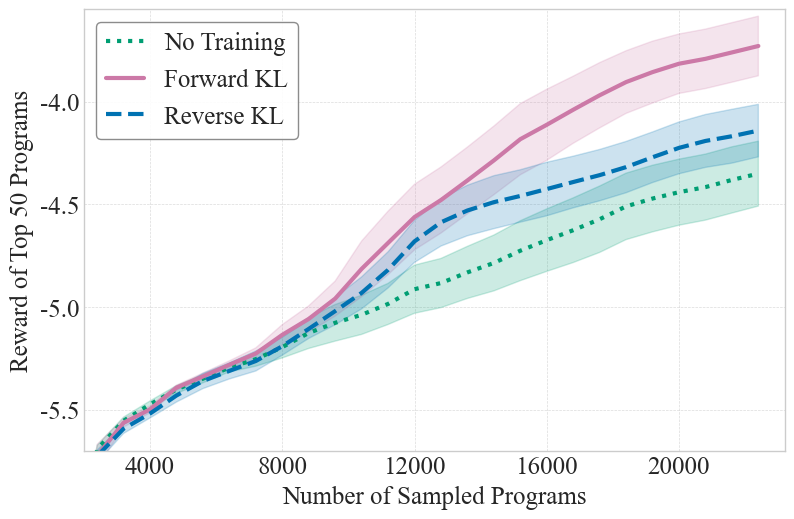

In [110]:
font_size = 18
figname = "ablation"

plt.style.use('seaborn-v0_8-whitegrid')

font_family = 'Times New Roman'  # Change to desired font

legend_name_map = {
    "sweepfinalicml-s2": "Forward KL",
    "sweepfinalreverse-s2": "Reverse KL",
    "sweepfinalicml-b": "No Training",
}

line_style_map = {
    "sweepfinalicml-s2": "solid",
    "sweepfinalreverse-s2": "dashed",
    "sweepfinalicml-b": "dotted",
}

color_map = {
    "sweepfinalicml-s2": "#CC79A7",   # Reddish Purple (colorblind-friendly)
    "sweepfinalreverse-s2": "#0072B2",     # Blue (colorblind-friendly)
    "sweepfinalicml-b": "#009E73",     # Bluish Green (colorblind-friendly)
}

fig, ax = plt.subplots(figsize=(8, 5))

for label, data in averaged_metrics.items():
    sweep, identifier = label.split('-')
    plt.plot(
        data["round_num"],
        data["unique_scores"],
        label=legend_name_map.get(f"{sweep}-{identifier}"),
        color = color_map.get(f"{sweep}-{identifier}"),
        linestyle=line_style_map.get(f"{sweep}-{identifier}"),
        # marker=marker_map.get(identifier, "o"), 
        linewidth=linewidth,
    )
    plt.fill_between(
        data["round_num"],
        data["unique_scores"] - data["std_error"],
        data["unique_scores"] + data["std_error"],
        color=color_map.get(f"{sweep}-{identifier}"),
        alpha=0.2
    )

# Add a legend with a visible frame
# legend = ax.legend(loc="upper left", fontsize=font_size, frameon=True)
legend = ax.legend(loc="upper left", 
                   fontsize=font_size, 
                   frameon=True, 
                   handlelength=1.5, 
                   )
legend.get_frame().set_edgecolor("grey")  # Set frame color
legend.get_frame().set_alpha(0.9)  # Set legend transparency
for text in legend.get_texts():
    text.set_fontfamily(font_family)

# # Improve ticks and grid
ax.tick_params(axis="both", which="major", labelsize=font_size)
ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontfamily(font_family)

# Tight layout to avoid overlap
plt.tight_layout()

# Define a formatter function that divides the axis value by 100
def scale_formatter(x, pos):
    return f"{x/100:.1f}"

# Define a formatter function that divides the axis value by 100
def x_formatter(x, pos):
    return f"{x*8:.0f}"

# Apply this formatter to the y-axis
ax.yaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))
ax.xaxis.set_major_formatter(mtick.FuncFormatter(x_formatter))

# Keep the original y-limits, so the plot itself doesn't move
ax.set_ylim([-570, -355])
ax.set_xlim([250, 2900])

# Labels and title
ax.set_xlabel("Number of Sampled Programs", fontsize=font_size, fontfamily=font_family)
ax.set_ylabel("Reward of Top 50 Programs", fontsize=font_size,fontfamily=font_family)


# Save improved plot
plt.savefig(f"{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{figname}.pdf", dpi=300, bbox_inches="tight")

# Display plot
plt.show()

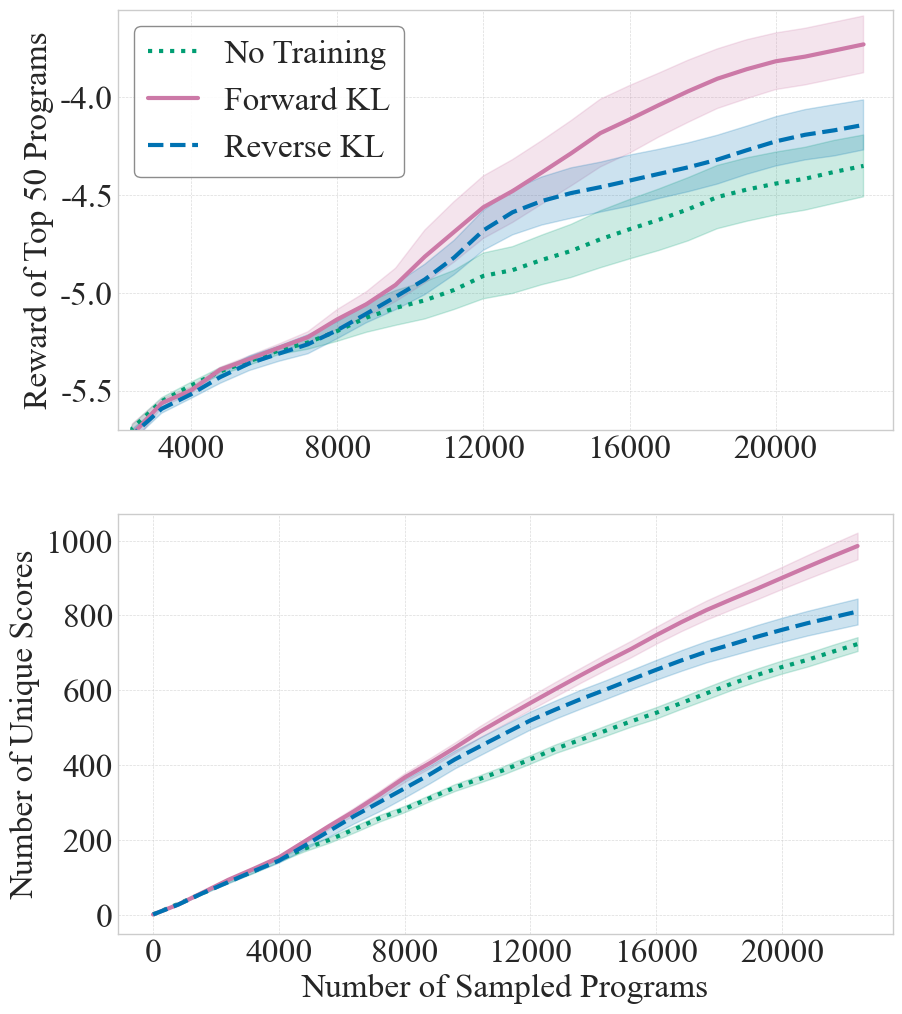

In [177]:
# create a 4x3 grid of plots, 4 rows for round nums, 3 columns for models
import matplotlib.ticker as ticker
# trained and baseline on the same plot across rounds, averaged across seeds
figname = "ablation"
font_size = 24
tasks = ["tsp"]
# labelpad= 15
fig_width = 10 #18
font_family = 'Times New Roman'  # Change to desired font
fig_height = 12 #8
# round_num_to_budget = {100: "1.6", 1100: "9.6", 1900: "16k", 2700: "22.4k"}
# round_num_to_budget = {100: "1600", 1100: "9600", 1900: "16000", 2700: "22400"}


fig, axs = plt.subplots(2, 1, figsize=(fig_width, fig_height))
for j, metric_key in enumerate(all_metrics.keys()):

    for i, model_name in enumerate(["phi"]):

        for label, data in all_metrics[metric_key].items():
            sweep, identifier = label.split('-')
            axs[j].plot(
                data["round_num"],
                data["unique_scores"],
                label=legend_name_map.get(f"{sweep}-{identifier}"),
                color = color_map.get(f"{sweep}-{identifier}"),
                linestyle=line_style_map.get(f"{sweep}-{identifier}"),
                # marker=marker_map.get(identifier, "o"), 
                linewidth=linewidth,
            )
            axs[j].fill_between(
                data["round_num"],
                data["unique_scores"] - data["std_error"],
                data["unique_scores"] + data["std_error"],
                color=color_map.get(f"{sweep}-{identifier}"),
                alpha=0.2
            )

            for text in legend.get_texts():
                text.set_fontfamily(font_family)

            if metric_key == "Best 50 scores overall":
                # Add a legend with a visible frame
                # legend = ax.legend(loc="upper left", fontsize=font_size, frameon=True)
                legend = axs[j].legend(loc="upper left", 
                                fontsize=font_size, 
                                frameon=True, 
                                handlelength=1.5, 
                                )
                
                for text in legend.get_texts():
                    text.set_fontfamily(font_family)
                legend.get_frame().set_edgecolor("grey")  # Set frame color
                legend.get_frame().set_alpha(0.9)  # Set legend transparency

                # # Tight layout to avoid overlap
                # plt.tight_layout()

                # Define a formatter function that divides the axis value by 100
                def scale_formatter(x, pos):
                    return f"{x/100:.1f}"

                # Define a formatter function that divides the axis value by 100
                def x_formatter(x, pos):
                    return f"{x*8:.0f}"

                # Apply this formatter to the y-axis
                axs[j].yaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))

                # Keep the original y-limits, so the plot itself doesn't move
                axs[j].set_ylim([-570, -355])
                axs[j].set_xlim([250, 2900])

                # Labels and title
                axs[j].set_ylabel("Reward of Top 50 Programs", fontsize=font_size, fontfamily=font_family)

            if metric_key == "Number of unique scores in program bank":
                axs[j].set_ylabel("Number of Unique Scores", fontsize=font_size,fontfamily=font_family)
            
                axs[j].set_xlabel("Number of Sampled Programs", fontsize=font_size, fontfamily=font_family)

            axs[j].xaxis.set_major_formatter(mtick.FuncFormatter(x_formatter))

            # # Improve ticks and grid
            axs[j].tick_params(axis="both", which="major", labelsize=font_size)
            axs[j].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            for label in axs[j].get_xticklabels() + axs[j].get_yticklabels():
                label.set_fontfamily(font_family)

            
            # # # Improve ticks and grid
            # axs[j].tick_params(axis="both", which="major", labelsize=font_ticks, pad=15)
            # axs[j].grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
            # # axs[j].xaxis.set_major_locator(ticker.MultipleLocator(100))
            # # print(min_score, max_score)
            # # axs[j].set_xlim((min_score-50), (max_score+50))
            # axs[j].set_xlim(-(max_score+50), -(min_score))
            # for label in axs[j].get_xticklabels() + axs[j].get_yticklabels():
            #     label.set_fontfamily(font_family)
            # axs[j].xaxis.set_major_formatter(mtick.FuncFormatter(scale_formatter))
            
            # legend = axs[j].legend(
            # loc='upper left',         # place it above the plot
            # # bbox_to_anchor=(0.5, 1.20), # adjust the y-value to move legend up/down
            # ncol=1,                     # number of columns in the legend
            # fontsize=font_ticks,
            # frameon=True, 
            # handlelength=1.1,        
            # )
            # handles, labels = axs[j].get_legend_handles_labels()
            # legend = axs[j].legend(
            #     handles[::-1], labels[::-1],  # Reverse the order
            #     loc='upper right',
            #     ncol=1,
            #     fontsize=font_ticks-4,
            #     frameon=True,
            #     handlelength=1.1,
            # )

            # #legend = ax.legend(loc="upper left", fontsize=font_ticks, frameon=True)
            legend.get_frame().set_edgecolor("grey")  # Set frame color
            legend.get_frame().set_alpha(0.9)  # Set legend transparency
            for text in legend.get_texts():
                text.set_fontfamily(font_family)

# Get current positions
pos1 = axs[0].get_position()
pos2 = axs[1].get_position()

# plt.subplots_adjust(wspace=0.25)

# plt.show()
plt.savefig(f"{task}_{figname}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{task}_{figname}.pdf", dpi=300, bbox_inches="tight")

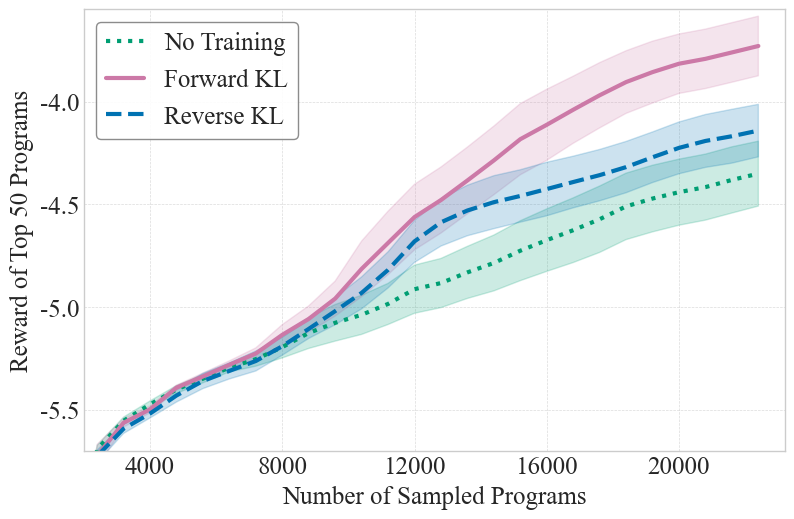